# PPCA in PyStan - Part 2: Setting up the PyStan environment
In part 1, we managed to reproduce $x$ with our PPCA model in PyStan, but the estimates of our parameters were not accurate. Specifically, we ended up with a latent dataset $z$ in which all points were close to zero. In part 2, we will try to approach the true values of these values more accurately.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

import os
os.sys.path.append('../Python')
from ppca import PPCA
from rotation_check import rotation_check

## indentifying the problem

Suppose we have a model in PyStan in which the prior over $z$ is specified. Let's take a look at the outcome of our estimates.

In [39]:
prior = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
    
    // prior over z    
    to_vector(z) ~ normal(0.0,1.0);
}
"""
ppca_pystan_prior = pystan.StanModel(model_code=prior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be3b7183348a59bc1ef8563bc7f7dd59 NOW.


We specify our parameters and generate some data.

In [3]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z),sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

And then we can optimize our parameters and latent dataset.

In [10]:
op_prior = ppca_pystan_prior.optimizing(data=ppca_dat)

z_p = op_prior['z']
sigma_p = op_prior['sigma']
W_p = op_prior['W']
x_p = np.random.normal(np.matmul(W_p,z_p),sigma_p)

In [11]:
fit = ppca_pystan_prior.sampling(data=ppca_dat, iter=50, chains=1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [29]:
np.std(fit.summary()['summary'][:2001,0])

0.8590265964759616

Let's compare our models with the real values and the values as found by Tipping & Bishops PPCA method.

In [5]:
print('real variance: ', sigma**2)
# print('PPCA variance (em): ', sigma_ppca_em)    # Since closed form- and EM PPCA have the same solutions, I left the EM solution out
print('simulated variance (prior): ', sigma_p**2)  # According to the docs (https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html),
                                             # the scale refers to the std. dev., but in their formulae they use sigma as the variance.
print()
print('real z: ', z)
print('simulated z (prior): ', z_p)
print()
print('real W: ', W)
print('simulated W (prior): ', W_p)
print()

real variance:  1.4098369497380756
simulated variance (prior):  0.46418758144830474

real z:  [[-0.14543584 -0.41574576  0.31851096 ... -0.48988294 -1.69576291
   1.68475197]
 [-0.15500637  0.83958055  1.014895   ... -0.19296372  0.70321252
  -0.17316202]]
simulated z (prior):  [[ 5.18951334e-04  4.83437851e-04 -5.00123082e-04 ... -8.59934802e-04
   1.32135649e-03 -2.02420241e-03]
 [-1.62832924e-04 -5.24184754e-04  9.55794123e-04 ... -1.03612234e-05
  -1.33921873e-03  1.89179732e-03]]

real W:  [[-1.29285391 -0.40738323]
 [-0.64510252  0.44604597]
 [-0.37274798  0.47029434]]
simulated W (prior):  [[ -985.54050865 -2902.52089115]
 [ 1981.73105832  1052.65881041]
 [ 1993.6269501   1466.25570775]]



We see that the prior over $z$ causes our latent data to be very close to zero, whereas defining no prior leaves us with very large values. According to our model, $z$ is a Gaussian $\mathcal{N}(0,1)$. Let's see what latent distribution our models generate.

In [6]:
print('Model with prior: p(z) = N(z|',np.mean(z_p, axis=1),',',np.std(z_p, axis=1),')')

Model with prior: p(z) = N(z| [-1.56757601e-05  1.51199370e-05] , [0.00094391 0.00086922] )


Strangely, the model with the specified prior does not produce samples of $z$ according to the given distribution: although the mean is close to zero, the std. dev. is too! This can be explained as follows. PyStan takes only 'parameters' and expected missing data is treated as a parameter as well. PyStan recieves the command to optimize all parameters according to their likelihood. The original PPCA model does not estimate $z$, it merely takes its distribution into account. PyStan, in contrast, optimizes $z$ to its prior. Since $z$ comes from a zero-centered Normal dsitribution, values of $z$ are most likely when close to zero Hence, PyStan generates $N\times M$ estimates of $z$ that are all close to zero. In turn, this is compensated by a $W$ with very large values, which is totally possible as the values of $W$ have flat priors without further restrictions. If we want PyStan to find accurate values for the other parameters, it shall be necessary to eliminate the option to optimize $z$ to its zero-mean.

In [7]:
no_prior = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
}
"""
ppca_pystan_no_prior = pystan.StanModel(model_code=no_prior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_079f555cbce9fa855a4015bfa2e456f9 NOW.


In [8]:
op_no_prior = ppca_pystan_no_prior.optimizing(data=ppca_dat)

z_np = op_no_prior['z']
sigma_np = op_no_prior['sigma']
W_np = op_no_prior['W']
x_np = np.random.normal(np.matmul(W_p,z_p),sigma_np)

In [9]:
print('real variance: ', sigma**2)
print('simulated variance: (no prior)', sigma_np**2)
print()
print('real z: ', z)
print('simulated z (no prior): ', z_np)
print()
print('real W: ', W)
print('simulated W (no prior): ', W_np)
print()

real variance:  1.4098369497380756
simulated variance: (no prior) 0.5769695981104104

real z:  [[-0.14543584 -0.41574576  0.31851096 ... -0.48988294 -1.69576291
   1.68475197]
 [-0.15500637  0.83958055  1.014895   ... -0.19296372  0.70321252
  -0.17316202]]
simulated z (no prior):  [[  28.01337658  -71.20755745  101.46562018 ...  -17.0978927
   -61.39489306  196.04233288]
 [ -30.70190898 -569.31615667  635.64218616 ...  345.49622733
  -671.35077161 1770.1754329 ]]

real W:  [[-1.29285391 -0.40738323]
 [-0.64510252  0.44604597]
 [-0.37274798  0.47029434]]
simulated W (no prior):  [[-0.00384161 -0.00130573]
 [ 0.02270431 -0.00397317]
 [ 0.02815275 -0.00349582]]



We see that the prior over $z$ causes our latent data to be very close to zero, whereas defining no prior leaves us with very large values. According to our model, $z$ is a Gaussian $\mathcal{N}(0,1)$. Let's see what latent distribution our models generate.

In [10]:
print('Model without prior: p(z) = N(z|',np.mean(z_np, axis=1),',',np.std(z_np, axis=1),')')

Model without prior: p(z) = N(z| [ 1.6540633  14.42428622] , [116.94639159 851.49764237] )


The model without a prior doesn't generate samples that are too close to the mean anymore The sampled values do not adhere to the given distribution either, but that was to be expected since we specified not prior. 
The plots below show that both models manage to reproduce $x$, but with very different latent datasets (note the scale on the axes).

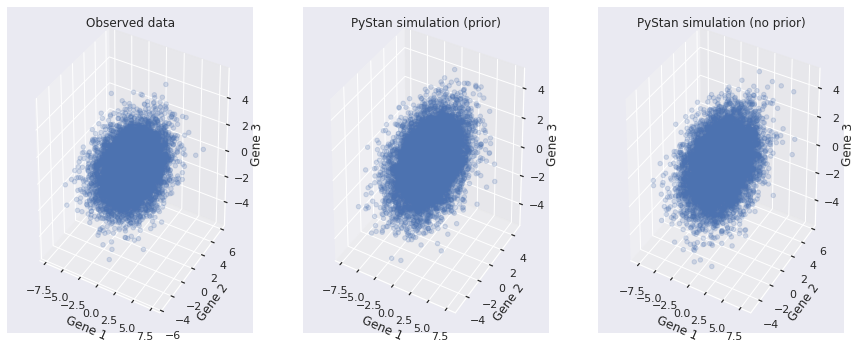

In [11]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.2)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(x_p[0,:],x_p[1,:],x_p[2,:], alpha=0.2)
ax.set_title('PyStan simulation (prior)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(x_np[0,:],x_np[1,:],x_np[2,:], alpha=0.2)
ax.set_title('PyStan simulation (no prior)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

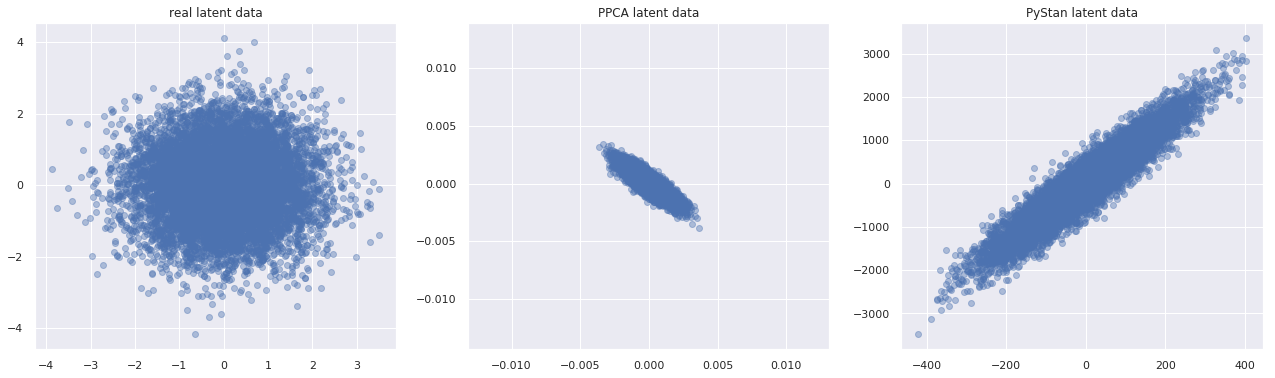

In [12]:
fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(1,3,1)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,3,2)
ax.scatter(z_p[0,:], z_p[1,:], alpha=0.4)
ax.set_title('PPCA latent data')
ax = fig.add_subplot(1,3,3)
ax.scatter(z_np[0,:], z_np[1,:], alpha=0.4)
ax.set_title('PyStan latent data')
plt.show()

## How does PyStan deal with this?
The [following piece of code](https://mc-stan.org/docs/2_22/stan-users-guide/missing-data.html) is taken from the [Stan Users Guide](https://mc-stan.org/docs/2_22/stan-users-guide/index.html). Let's see how PyStan deals with missing data. The following script is supposed to estimate missing values given a set of observed data, by estimating the mean and standard deviation of the observed data.

In [31]:
missingdata = '''
data {
  int<lower=0> N_obs;
  int<lower=0> N_mis;
  real y_obs[N_obs];
}
parameters {
  real mu;
  real<lower=0> sigma;
  real y_mis[N_mis];
}
model {
  y_obs ~ normal(mu, sigma);
  y_mis ~ normal(mu, sigma);
}
'''
miss = pystan.StanModel(model_code=missingdata)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a20f82b4a27dcf682c721571cfaabdf3 NOW.


In [32]:
N_obs = 1000
N_mis = 100
a = np.random.normal(5,3,size=N_obs)
md_dat = {'N_obs': N_obs, 'N_mis':N_mis, 'y_obs':a}
op = miss.optimizing(data=md_dat)
y = op['y_mis']

print('First missing values: ', y[:6])
print('Mean of the filled in missing data: ', np.mean(y))
print('Standard deviation of the filled in missing data: ', np.std(y))

First missing values:  [5.06564516 5.06576903 5.06563926 5.06574005 5.06575618 5.06575599]
Mean of the filled in missing data:  5.0657102869983985
Standard deviation of the filled in missing data:  4.843609245465154e-05


As we can see, PyStan is perfectly able to estimate the mean and standard deviation of the observed data. However, when finding the values of the missing data, the scipt doesn't generate values that follow the found distribution, but attempts to return values with the highest likelihood. This is the same problem we encounter in our PPCA problem. It looks like we need a differrent approach than using the 'optimizing()'-method to obtain point estimates. The 'sampling()'-method might be more suitable. This method generates multiple samples, we use the sample with the highest likelihood. This is very unlikely to be the precise *maximum* likelihood, it is just the most likely set of parameters that we happened to have sampled.

In [33]:
fit = miss.sampling(data = md_dat, iter=100, chains=1)
b = fit.extract()

best_ind = np.where(b['lp__']==max(b['lp__']))[0][0]

[]

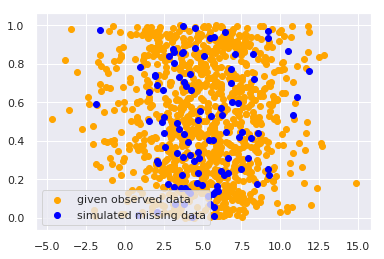

In [34]:
plt.scatter(a, np.random.uniform(size=N_obs), color='orange', label='given observed data')
plt.scatter(b['y_mis'][best_ind,:], np.random.uniform(size=N_mis), color='blue', label='simulated missing data')
plt.legend()
plt.plot()

This works better, we generate samples for each of the 100 missing datapoints and they are generated from the right distribution.

In [36]:
print('mean standard deviation of best sample: ', np.std(b['y_mis'][best_ind]))
print('mean average of best sample: ', np.mean(b['y_mis'][best_ind,:]))

mean standard deviation of best sample:  2.5227269838313595
mean average of best sample:  4.9730921130979615


### Applying our solution to the latent variable model

Now we apply this method to the latent variable model. We generate multiple samples and take the average of all samples of $\sigma$ and $W$ as our best guess, but for $z$ we should not do this, as the mean of all guesses will just converge back to the mean of $z$.

In [56]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z),sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

In [57]:
fit = ppca_pystan_prior.sampling(data=ppca_dat, iter=2000, chains=1)
fitreturn = fit.extract()
best_ind = np.where(fitreturn['lp__']==max(fitreturn['lp__']))[0][0]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [58]:
ppca = PPCA()
ppca.fit(x.T, mu = np.zeros(D)[np.newaxis].T)
mu_ppca, sigma_ppca, W_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(W_ppca, x)[0]

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [60]:
print('Real sigma: ', sigma)
print('PyStan sigma', fitreturn['sigma'][best_ind])
print('PPCA sigma: ', np.sqrt(sigma_ppca))
print()
print('Real WW^T:\n',np.matmul(W,W.T))
print('PyStan WW^T:\n',np.matmul(fitreturn['W'][best_ind],fitreturn['W'][best_ind].T))
print('PPCA WW^T:\n', np.matmul(W_ppca,W_ppca.T))

Real sigma:  1.5121666878772477
PyStan sigma 1.3794838615589062
PPCA sigma:  1.4658811886923857

Real WW^T:
 [[ 6.27881947 -3.63125331 -5.75505084]
 [-3.63125331  5.19332418  4.79899648]
 [-5.75505084  4.79899648  5.97418413]]
PyStan WW^T:
 [[ 6.21518514 -3.46840771 -5.88283524]
 [-3.46840771  5.73591722  5.01079319]
 [-5.88283524  5.01079319  6.35383618]]
PPCA WW^T:
 [[ 5.98429553 -4.80546795 -4.97580588]
 [-4.80546795  7.26215141  4.13647014]
 [-4.97580588  4.13647014  4.14309747]]


As we can see, the sampled $\sigma$ is almost equal to the actual $\sigma$, and the sampled $W$ is almost a perfect rotation of the actual $W$.
 We can also assure that $z$ follows the correct distribution of $\mathcal{N}(0,1)$.

In [61]:
print('Average mean of PyStan z: ',np.mean(fitreturn['z'][best_ind], axis=1))
print('Average standard deviation of z: ',np.std(fitreturn['z'][best_ind]))
print()
print('Average mean of PPCA z: ',np.mean(z_ppca, axis=1))
print('Average standard deviation of PPCA z: ',np.std(z_ppca, axis=1))

Average mean of PyStan z:  [-0.00926231 -0.01266285]
Average standard deviation of z:  0.9531057252756019

Average mean of PPCA z:  [-0.01812899  0.00761414]
Average standard deviation of PPCA z:  [1.05492508 1.40872221]


### Adding $\mu$ again

In [2]:
latent_mu = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
    vector[D] mu;   //  added means
}

model{
    //  priors
    to_vector(z) ~ normal(0.0,1.0);
    //for (d in 1:D){
    //    W[d] ~ normal(0.0,sigma);
    //    mu[d]~normal(0.0, 5.0) ;
    //    }
    //sigma~lognormal(0.0, 1.0) ;
    
    
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n)+mu, sigma);
        
}
"""
ppca_pystan_mu = pystan.StanModel(model_code=latent_mu)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_105ba88cde53b0932d23ebb13d8d6597 NOW.


In [63]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
mu = np.random.normal(0,15,size=(D,1))
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z)+mu,sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

In [65]:
fit = ppca_pystan_mu.sampling(data=ppca_dat, iter=2000, chains=1)
fitreturn = fit.extract()

best_ind = np.where(fitreturn['lp__']==max(fitreturn['lp__']))[0][0]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Again, we obtain an accurate guess for $\sigma$ and $W$.

In [66]:
ppca = PPCA()
ppca.fit(x.T)
mu_ppca, sigma_ppca, W_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(W_ppca, x)[0]

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [69]:
print('Real mu:\n', mu)
print('Sampled mu mean:\n', fitreturn['mu'][best_ind])
print('PPCA mu:\n', mu_ppca)
print()
print('Real sigma: ', sigma)
print('Sampled sigma mean: ', fitreturn['sigma'][best_ind])
print('PPCA sigma: ', np.sqrt(sigma_ppca))
print()
print('Real WW^T:\n',np.matmul(W,W.T))
print('Sampled WW^T:\n',np.matmul(fitreturn['W'][best_ind],fitreturn['W'][best_ind].T))
print('PPCA WW^T:\n', np.matmul(W_ppca,W_ppca.T))


Real mu:
 [[-34.89496438]
 [ 19.62559038]
 [ 14.63380637]]
Sampled mu mean:
 [-34.9647814   19.66070583  14.54522255]
PPCA mu:
 [[-35.10232913]
 [ 19.68118365]
 [ 14.58744059]]

Real sigma:  2.346859153523516
Sampled sigma mean:  2.3205115844535986
PPCA sigma:  2.4367414326637036

Real WW^T:
 [[ 16.42802655 -15.51887653  15.64141368]
 [-15.51887653  14.73531232 -15.18967475]
 [ 15.64141368 -15.18967475  17.16814958]]
Sampled WW^T:
 [[ 16.24382856 -15.20907611  15.46523452]
 [-15.20907611  14.48394011 -15.41071316]
 [ 15.46523452 -15.41071316  18.27781301]]
PPCA WW^T:
 [[ 14.9377647  -17.3487841   10.51317288]
 [-17.3487841   20.49287753 -12.8202564 ]
 [ 10.51317288 -12.8202564    8.48182735]]


And a well-distributed $\bar{z}$.

In [68]:
print('Average mean of z (PyStan): ',np.mean(np.mean(fitreturn['z'], axis=2), axis=0))
print('Average standard deviation of z (PyStan): ',np.mean(np.std(fitreturn['z'], axis=2), axis=0))
print()
print('Average mean of z (PPCA): ',np.mean(z_ppca, axis=1))
print('Average standard deviation of z (PPCA): ',np.std(z_ppca, axis=1))

Average mean of z (PyStan):  [0.00203851 0.00072226]
Average standard deviation of z (PyStan):  [0.99761101 0.99790486]

Average mean of z (PPCA):  [ 4.21999686 38.62207132]
Average standard deviation of z (PPCA):  [1.04538475 3.19169059]
